<h2> Analysis of Height and Weight in MrOS V1 Data (EDA1.ipynb) </h2> 

The purpose of this workbook is take begin exploring the vast amount of data that we have.  Through various methods of exploration, we hope to find general trends, patterns, and correlations in the data that will help lead to us a reliable predictive model. 

#### 1. [Installation and Importing of Libraries](#eda_import)
#### 2. [Retreival of Data](#eda_retrieval)
#### 3. [Exploration of NA Values](#eda_na)
#### 4. [Descriptive Statistics](#eda_describe)

### <a name="eda_import"></a>Installation and Importing of Libraries
In order to both explore and visualize the data, it's necessary for us to load various libraries.  In addition to loading already pre-installed libraries, we've also had to install seaborn for plotting. 

In [2]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.12.2)


In [3]:
##import libraries required for analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.decomposition import PCA
import mpl_toolkits.mplot3d
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer


In [4]:
sns.__version__

'0.12.2'

### <a name="eda_retrieval"></a>Retreival of Data
The data needs to be retrieved from the Postgres database and stored in a dataframe for us to begin analyzing.

As we've described, the dataset is very wide and in order to properly analyze, we need to reduce the number of features we're looking at. 
From the v1aug16_raw table, we're limiting the columns to values containing height and weight data using regular expressions (columns begin with HW).

In [5]:
##Connect to Postgre
import psycopg2
import sqlalchemy
import getpass
import pandas as pd 

user = "hallty"
host = "pgsql.dsa.lan"
database = "casestdysu23t03"
password = getpass.getpass()
connectionstring = "postgresql://" + user + ":" + password + "@" + host + "/" + database
engine = sqlalchemy.create_engine(connectionstring)
connection = None

try:
    connection = engine.connect()
except Exception as err:
    print("An error has occurred trying to connect: {}".format(err))

del password

········


In [6]:
query = "SELECT * FROM public.v1_form_hw"
hw = pd.read_sql_query(query, con=connection)

In [7]:
hw

,ID,HWSTAFF,HWMEAS1,HWMEAS2,HWGT4,HWMEAS3,HWMEAS4,HWKYPH,HWWGT,HWPULSE1,HWPULSE2,HWPULSEM,HWHGT,HWBMI,HWHTLOSS,HWWTLS25,HW
0,BI0001,BI99,1728.0,1727.0,0.0,NaN,NaN,0.0,87.8,54.0,52.0,53.0,172.75,29.4211,-0.03,10.68970,1.0
1,BI0002,BI16,1767.0,1765.0,0.0,NaN,NaN,0.0,99.4,60.0,62.0,61.0,176.60,31.8717,6.28,20.02170,1.0
2,BI0003,BI01,1784.0,1785.0,0.0,NaN,NaN,0.0,83.1,76.0,72.0,74.0,178.45,26.0956,4.43,3.72175,1.0
3,BI0004,BI16,1847.0,1846.0,0.0,NaN,NaN,0.0,97.4,72.0,70.0,71.0,184.65,28.5667,3.31,36.16540,1.0
4,BI0005,BI01,1688.0,1687.0,0.0,NaN,NaN,0.0,82.9,64.0,62.0,63.0,168.75,29.1117,-18.89,17.12940,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5989,SD9014,SD03,1658.0,1658.0,0.0,NaN,NaN,0.0,54.2,66.0,66.0,66.0,165.80,19.7165,1.84,4.30510,1.0
5990,SD9015,SD04,1689.0,1690.0,0.0,NaN,NaN,0.0,82.0,52.0,50.0,51.0,168.95,28.7275,1.23,2.62175,1.0
5991,SD9016,SD06,1719.0,1719.0,0.0,NaN,NaN,0.0,70.0,52.0,52.0,52.0,171.90,23.6890,-4.26,6.49740,1.0
5992,SD9017,SD03,1809.0,1810.0,0.0,NaN,NaN,0.0,95.0,60.0,58.0,59.0,180.95,29.0139,1.93,34.21890,1.0


### <a name="eda_na"></a>Exploration of NA Values
Lot of NaN values in our dataset. We'll explore, as well as provide some reasoning for why null values are handled in certain ways below. Thankfully, our dataset comes with a lot of documentation. Referring to the annotated form used for clinical interviews provides insight here. 

In [8]:
print(pd.DataFrame(hw.isna().sum(), columns=['Missing Values']))


          Missing Values
ID                     0
HWSTAFF                0
HWMEAS1                7
HWMEAS2                8
HWGT4                  0
HWMEAS3             5768
HWMEAS4             5770
HWKYPH                 0
HWWGT                  0
HWPULSE1              15
HWPULSE2              15
HWPULSEM              15
HWHGT                  7
HWBMI                  7
HWHTLOSS               8
HWWTLS25               1
HW                     0


In [9]:
# Drop the ID and HWSTAFF columns
hw = hw.drop(columns=['HWSTAFF', 'HW', 'HWMEAS3', 'HWMEAS4'])
hw_with_nulls = hw

# Fill missing values in the other columns with their mean (for numerical data)
num_cols = ['HWMEAS1', 'HWMEAS2', 'HWPULSE1', 'HWPULSE2', 'HWPULSEM', 'HWHGT', 'HWBMI', 'HWHTLOSS', 'HWWTLS25']
for col in num_cols:
    hw[col].fillna(hw[col].mean(), inplace=True)



In [10]:
print(pd.DataFrame(hw.isna().sum(), columns=['Missing Values']))


          Missing Values
ID                     0
HWMEAS1                0
HWMEAS2                0
HWGT4                  0
HWKYPH                 0
HWWGT                  0
HWPULSE1               0
HWPULSE2               0
HWPULSEM               0
HWHGT                  0
HWBMI                  0
HWHTLOSS               0
HWWTLS25               0


In [11]:
# Renaming columns for better interpretability
hw = hw.rename(columns={
    'HWMEAS1': 'StandingHeight_Meas1',
    'HWMEAS2': 'StandingHeight_Meas2',
    'HWGT4': 'HeightDiff_GTE_4mm',
    'HWKYPH': 'SidewaysDueToKyphosis',
    'HWWGT': 'Weight_kg',
    'HWPULSE1': 'RadialPulse_Meas1',
    'HWPULSE2': 'RadialPulse_Meas2',
    'HWPULSEM': 'RadialPulse_Avg',
    'HWHGT': 'AvgHeight_cm',
    'HWBMI': 'BMI',
    'HWHTLOSS': 'HeightChangeFrom25',
    'HWWTLS25': 'WeightChangeFrom25'
})

# Let's check the renamed dataframe
print(hw.head())


       ID  StandingHeight_Meas1  StandingHeight_Meas2  HeightDiff_GTE_4mm  \
0  BI0001                1728.0                1727.0                 0.0   
1  BI0002                1767.0                1765.0                 0.0   
2  BI0003                1784.0                1785.0                 0.0   
3  BI0004                1847.0                1846.0                 0.0   
4  BI0005                1688.0                1687.0                 0.0   

   SidewaysDueToKyphosis  Weight_kg  RadialPulse_Meas1  RadialPulse_Meas2  \
0                    0.0       87.8               54.0               52.0   
1                    0.0       99.4               60.0               62.0   
2                    0.0       83.1               76.0               72.0   
3                    0.0       97.4               72.0               70.0   
4                    0.0       82.9               64.0               62.0   

   RadialPulse_Avg  AvgHeight_cm      BMI  HeightChangeFrom25  \
0        

<a name="eda_describe"></a><h3> Descriptive Statistics </h3>
Below are a set of descriptive statistics meant to familiarize the audience

In [12]:
hw.describe().T

,count,mean,std,min,25%,50%,75%,max
StandingHeight_Meas1,5994.0,1741.342074,67.757847,1472.0000,1695.000000,1741.00000,1785.000000,1989.0000
StandingHeight_Meas2,5994.0,1741.550117,67.823201,1471.0000,1695.000000,1741.00000,1786.000000,1989.0000
HeightDiff_GTE_4mm,5994.0,0.044711,0.206687,0.0000,0.000000,0.00000,0.000000,1.0000
SidewaysDueToKyphosis,5994.0,0.011011,0.104363,0.0000,0.000000,0.00000,0.000000,1.0000
Weight_kg,5994.0,83.148582,13.289153,48.5000,73.700000,81.80000,91.000000,144.1000
RadialPulse_Meas1,5994.0,64.349891,9.989382,36.0000,58.000000,64.00000,70.000000,198.0000
RadialPulse_Meas2,5994.0,64.518816,9.999121,32.0000,58.000000,64.00000,70.000000,198.0000
RadialPulse_Avg,5994.0,64.434354,9.898104,36.0000,58.000000,63.00000,70.000000,198.0000
AvgHeight_cm,5994.0,174.148639,6.782385,147.1500,169.500000,174.10000,178.550000,198.9000
BMI,5994.0,27.378324,3.829940,17.2110,24.777850,26.90575,29.490625,50.6687


In [13]:
# Calculate correlation matrix
corr = hw.corr()

# Print correlation matrix
print(corr)


                       StandingHeight_Meas1  StandingHeight_Meas2  \
StandingHeight_Meas1               1.000000              0.998885   
StandingHeight_Meas2               0.998885              1.000000   
HeightDiff_GTE_4mm                 0.012907              0.016017   
SidewaysDueToKyphosis             -0.046381             -0.044845   
Weight_kg                          0.482872              0.482144   
RadialPulse_Meas1                 -0.029625             -0.031307   
RadialPulse_Meas2                 -0.023148             -0.024591   
RadialPulse_Avg                   -0.026642             -0.028219   
AvgHeight_cm                       0.999744              0.999310   
BMI                               -0.002641             -0.003275   
HeightChangeFrom25                -0.195215             -0.194474   
WeightChangeFrom25                 0.109953              0.109789   

                       HeightDiff_GTE_4mm  SidewaysDueToKyphosis  Weight_kg  \
StandingHeight_Meas1   

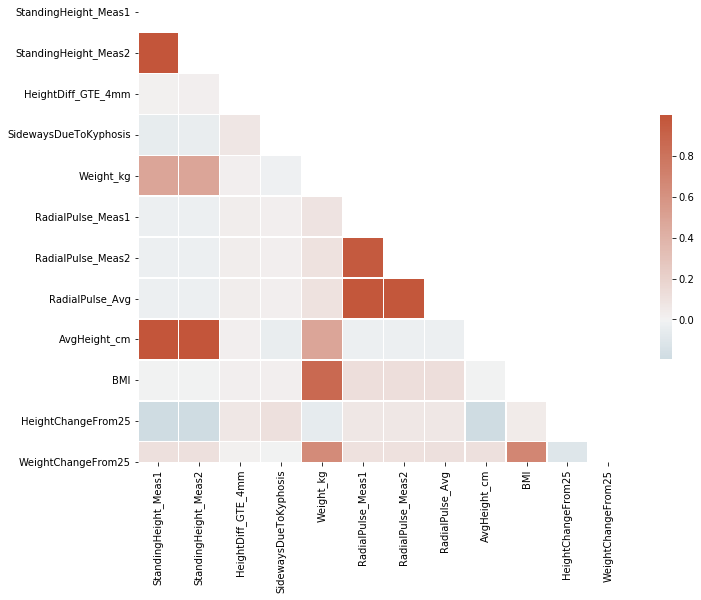

In [14]:
# Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

A lot of the highest correlations here make sense... one measure of height and weight is similar or near exact to another measure of height and weight. For instance, weight_kg and BMI and the multiple height measurements. The only somewhat interesting insights here are the negative correlation, while fairly weak, between "HeightChangeFrom25" and "StandingHeight_Meas1" indicating people with greater standing height have less height change since the age of 25 and WeightChangeFrom25" has a moderately strong positive correlation with "Weight_kg" (0.646205) and "BMI" (0.677727), suggesting that those who have gained more weight since age 25 are likely to have higher current weight and BMI. 

In [17]:
# Define the file path and name, export, set to 777
import os

file_path = "/dsa/groups/casestudy2023su/team03/model_data/hw_results.csv"
hw.to_csv(file_path, index=False)
os.chmod(file_path, 0o777)

file_path_with_nulls = "/dsa/groups/casestudy2023su/team03/model_data/null_included/HW_results_with_nulls.csv"
hw_with_nulls.to_csv(file_path_with_nulls, index=False)
os.chmod(file_path_with_nulls, 0o777)